```{margin} Adaptation!
This work was adapted from lecture notes in John Kitchin's excellent 06-623 course! His lecture notes are included in the helpful resources link if you want to know more details about how numerical methods work.
```

## More complicated example: Van der Pol oscillator

So far we have focused on computational solutions to first order differential equations, including systems of first order differential equations. The reason for that is simply that all numerical integration strategies only work with the first derivative.

Many differential equations involve higher order derivatives though. We can solve these by converting them to systems of first-order differential equations through a series of variable changes.

Let's consider the [Van der Pol oscillator](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator).

$\frac{d^2x}{dt^2} - \mu(1-x^2)\frac{dx}{dt} + x = 0$

We define a new variable: $v = x'$, and then have $v' = x''$.

That leads to a set of equivalent first-order differential equations:

$x' = v$

$v' - \mu (1-x^2)v + x = 0$

You can still think of $x$ as the position of the oscillator, and $y$ as the velocity of the oscillator. Now, we can integrate these equations from some initial condition.

Let's do this and plot the position and velocity of the oscillator. Rather than use `t_eval`, we will instead set the optional argument `max_step` to tell the solver how often it should make a step.

This is different than using `t_eval`, which uses interpolation *after* the solution has been found to evaluate the solution. This will become important later when we use events, which are only evaluated at the *solver* points.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp

mu = 0.2


def dXdt(t, X):
    x, v = X
    dxdt = v
    dvdt = mu * (1 - x**2) * v - x
    return np.array([dxdt, dvdt])


X0 = np.array((1, 2))  # you can pick any x0, and v0 you want.
tspan = np.array((0, 40))

dXdt(0, X0)

array([ 2., -1.])

In [2]:
teval, h = np.linspace(*tspan, 500, retstep=True)

sol = solve_ivp(dXdt, tspan, X0, max_step=h)
sol.message, sol.success, sol.y.T.shape

('The solver successfully reached the end of the integration interval.',
 True,
 (500, 2))

Now, we can plot the solutions.

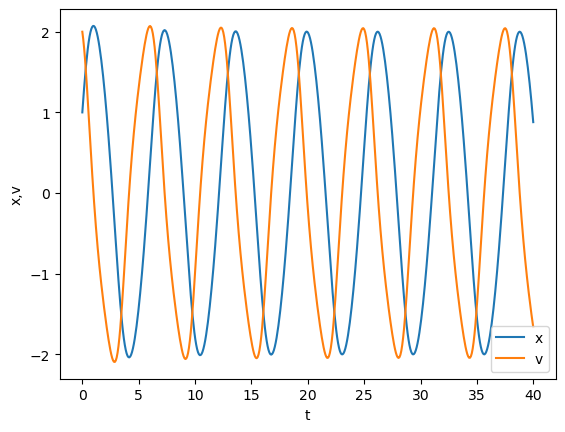

In [3]:
import matplotlib.pyplot as plt

plt.plot(sol.t, sol.y.T)
plt.xlabel("t")
plt.ylabel("x,v")
plt.legend(["x", "v"]);

You can see that the solution appears oscillatory. Let's be more quantitative than what it *looks* like. An alternative way to visualize this solution is called the phase portrait where we plot the two state variables (x, v) against each other. We include the starting point for visualization.

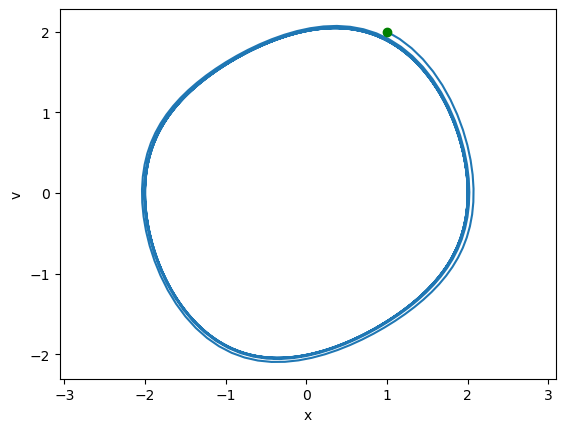

In [4]:
plt.plot(*sol.y)  # unpack the first row into x and second row into the y
# equivalent to plt.plot(sol.y[0], sol.y[1])
plt.plot(*sol.y[:, 0], "go")  # starting point
plt.xlabel("x")
plt.ylabel("v")
plt.axis("equal");

So, evidently it is not exactly periodic in the beginning, but seems to take some time to settle down into a periodic rhythm. That seems to be the case, because if it didn't we would expect to see a continued spiral in or out of this limit cycle. Another way we can assess this quantitatively is to look at the peak positions in our solution. We return to an event type of solution. We seek an event where the derivative $dx/dt=0$, and it is a maximum, which means $x'$ starts positive, becomes zero, and then is negative. Note this is appropriate for this problem, where there is only one, periodic maximum. For other problems, you might need a different approach.

Now, it is important to remember that the event function is only evaluated after a solver point, so we need to make sure the solver points bracket where events occur. This is accomplished by making sure that when we graph the solution from the solver (not from t_eval), that we can visually see where the events will occur.

In [5]:
def max_x_event(t, X):
    Xprime = dXdt(t, X)
    return Xprime[0]  # first derivative, dx/dt = 0


max_x_event.direction = -1  # event must go from positive to negative, i.e. a max

sol = solve_ivp(dXdt, tspan, X0, max_step=h, events=max_x_event)
print(sol.message)
sol.t_events[0]

The solver successfully reached the end of the integration interval.


array([ 0.98712369,  7.29961546, 13.60207133, 19.90194032, 26.2010961 ,
       32.50005162, 38.79895061])

In [6]:
print(sol.y_events[0])

[[ 2.07283325e+00 -1.38777878e-17]
 [ 2.02004874e+00  5.84601811e-16]
 [ 2.00590349e+00  5.55111512e-16]
 [ 2.00196134e+00 -3.21270788e-15]
 [ 2.00085100e+00  2.52575738e-15]
 [ 2.00053732e+00 -4.48252546e-15]
 [ 2.00044864e+00  6.62664368e-15]]


You can see we found seven events. We should plot them on the solution to see that they are in fact maxima. (what could possibly go wrong? if you get the wrong direction, then you will either see minima, or minima and maxima! If your event function is wrong, then it will just be wrong.)  Note we get two rows in our solution, one for x and one for v. From the numbers here, you can see that the x_max values seem to be settling down to about 2.0.

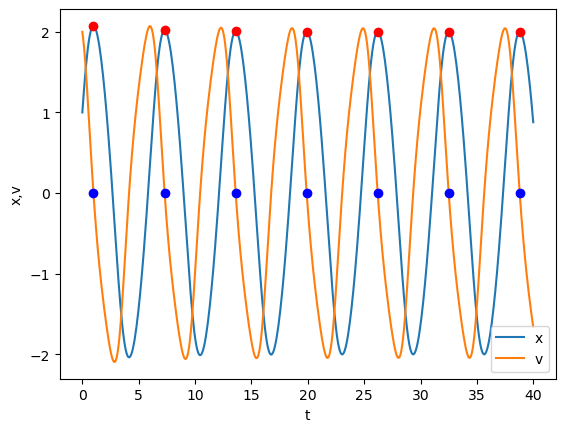

In [7]:
plt.plot(sol.t, sol.y.T)  # full solutions

# break up this calculation for ease of reading
te = sol.t_events[0]
xmax, v_at_xmax = sol.y_events[0].T
plt.plot(te, xmax, "ro")
plt.plot(te, v_at_xmax, "bo")

# compare to. Don't do this, it is confusing and hard to figure out.
# plt.plot(sol.t_events[0], sol.y_events[0][:, 0], 'k*')

plt.xlabel("t")
plt.ylabel("x,v")
plt.legend(["x", "v"]);

That looks good, the red dots appear at the maxima, and they are periodic, so now we can see how x<sub>max</sub> varies with time.

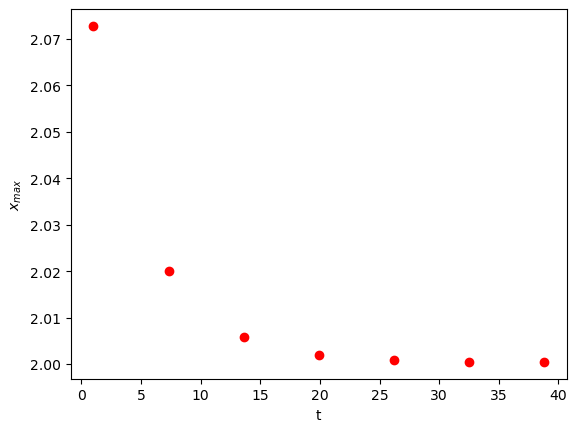

In [8]:
plt.plot(te, xmax, "ro")
plt.xlabel("t")
plt.ylabel("$x_{max}$");

You can see that after about 5 cycles, xmax is practically constant. We can also see that the period (the time between maxima) is converging to a constant. We cannot say much about what happens at longer times. You could integrate longer if it is important to know that. This is a limitation of numerical methods though. To *prove* that it will be constant, you need to do some analytical math that would show the period and x<sub>max</sub> go to a constant.

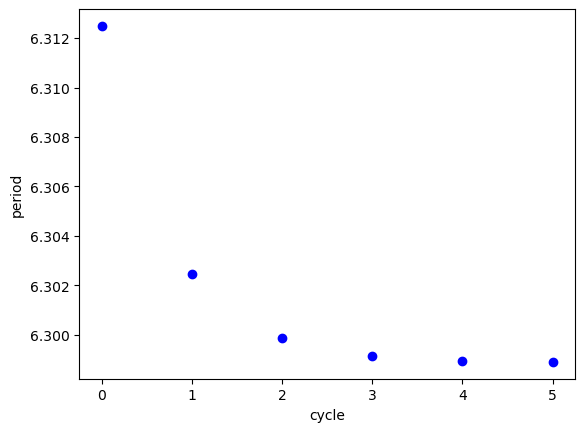

In [9]:
plt.plot(np.diff(te), "bo")
plt.xlabel("cycle")
plt.ylabel("period");

If we seek the steady state, oscillatory behavior of this system, we should discard the solutions in at least the first 4 cycles, since the maxima and periods are still changing.

In [10]:
te[-1], sol.y_events[0][-1]

(38.798950606192165, array([2.00044864e+00, 6.62664368e-15]))

Alternatively, we can use the last point as an initial value for a new integration that should be close to steady state oscillations.

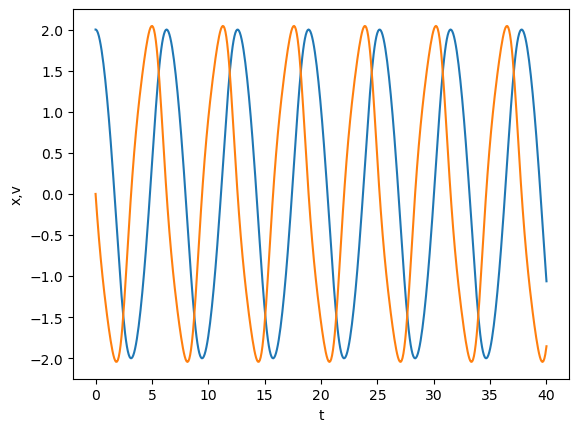

In [11]:
tspan = (0, 40)
X0 = sol.y_events[0][-1]

sol2 = solve_ivp(dXdt, tspan, X0, max_step=h, events=max_x_event)
plt.plot(sol2.t, sol2.y.T)
plt.xlabel("t")
plt.ylabel("x,v");

Here you see about 6 more cycles. The period of these events is practically constant.

In [12]:
sol2.t_events, np.diff(sol2.t_events[0])

([array([3.31307575e-15, 6.29888301e+00, 1.25977615e+01, 1.88966387e+01,
         2.51955156e+01, 3.14943923e+01, 3.77932690e+01])],
 array([6.29888301, 6.2988785 , 6.29887721, 6.29887685, 6.29887676,
        6.29887672]))

And the limit cycle shows practically a single curve.

(-2.2004040548071013,
 2.2004892419393975,
 -2.248591036725654,
 2.2485910192056817)

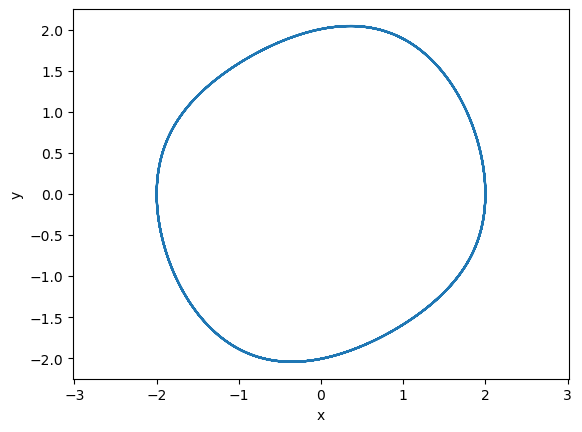

In [13]:
plt.plot(*sol2.y)
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
# makes x-ticks have the same dimension as y-ticks

This limit cycle shows the oscillatory behavior. You can see here that each cycle repeats on top of itself.